In [1]:
%matplotlib inline

# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import matplotlib.cm as cm, matplotlib.font_manager as fm

#reading the csv file
df = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv')
# df.head()

/Users/Alan/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (8,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


# Part (a)

In [2]:
df.Agency.unique()

array(['NYPD', 'TLC', 'DPR', 'DOHMH', 'DSNY', 'DOT', 'CHALL', 'DOF', 'HRA',
       'HPD', 'DEP', 'DOB', 'DHS', 'DCA', '3-1-1', 'DOE', 'OATH', 'FDNY',
       'DFTA', 'EDC', 'OPS', 'DOITT', 'NYCEM', 'NYCSERVICE', 'COIB'], dtype=object)

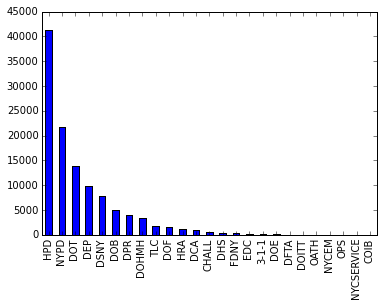

In [3]:
complaints = df.Agency.value_counts()
complaints.plot(kind = 'bar')

In [4]:
fraction_2nd_most_popular = np.float(complaints[complaints.index == 'NYPD'])/complaints.sum()
print np.round(fraction_2nd_most_popular,10)

0.1897961504


# Part (b)

In [5]:
#creating a copy of the dataframe
data = df.copy()
data.loc[:,'code'] = 1
boroughs = data.Borough.value_counts()
complaintTypes = data['Complaint Type'].value_counts()
CBgroups = data.groupby(by=['Complaint Type', 'Borough'], axis=0, as_index=False, group_keys=False)
cds = CBgroups.sum() #cumulated dataset
# cds.head()

In [6]:
cds.loc[:,'p(CTnB)'] = cds['code'].apply(lambda x: x*1.0/cds.code.sum())
cds.loc[:,'p(CT)'] = cds['Complaint Type'].apply(lambda x: float(complaintTypes[complaintTypes.index==x])/cds.code.sum())
cds.loc[:,'p(B)'] = cds['Borough'].apply(lambda x: float(boroughs[boroughs.index==x])/cds.code.sum())
cds.loc[:,'ratio'] = cds['p(CTnB)'].div(cds['p(CT)'].mul(cds['p(B)']))
# cds.head()

required = np.round(cds.ratio.max(), 10)
print required

26.7982188891


# Part (c)

What is the distance (in degrees) between the 90% and 10% percentiles of degrees latitude?

In [7]:
ans = np.round(data.Latitude.quantile(0.9) - data.Latitude.quantile(0.1), 10)
print ans

0.2307434642


# Part (d)
Let's estimate the area that 311 supports. Suppose calls are 2D normally distributed on the surface of the earth with mean and standard deviation given by those of the latitude and longitude. How many square kilometers is the single-standard-deviation ellipse?

In [8]:
# From http://www.longitudestore.com/how-big-is-one-gps-degree.html, at 40 deg N Latitude:
# One degree of latitude =  111.03 km or  68.99 mi
# One degree of longitude =  85.39 km or  53.06 mi
# #The mean lat and long are used to calculate the reference points to be used to calculate the respective distances
# import math
# rlat = mlat * math.pi/180  # reference latitude
# rlong = mlong * math.pi/180  # reference latitude
# # metres per degree latitude
# d_meters = 111132.92 - 559.82* math.cos(2*rlat) + 1.175 * math.cos(4*rlat) 
# d_Km = d_meters/1000

In [9]:
# mean Latitude and Longitude
import math
mlat = data.Latitude.mean()
mlong = data.Longitude.mean()
# print mlat, mlong

Lat_change = 111.03 # Km per degree
Long_change = 85.39 # Km per degree

# Area of ellipse = pi * a * b
a = data.Latitude.std() * Lat_change
b = data.Longitude.std() * Long_change
area = math.pi * a * b
print np.round(area, 10)

199.929067592


# Part (e)
What is the difference between the expected number of calls received during the most and least popular whole hours of the day? (Remove points which do not seem to accurately reflect the actual time they were reported.)

In [10]:
import re
def getHour(date):
    r = re.search('(\d+\/\d+\/\d+ )(\d+)(:\d+:\d+ )(.*)', date)
    return r.group(2)
def getPeriod(date):
    r = re.search('(\d+\/\d+\/\d+ )(\d+)(:\d+:\d+ )(.*)', date)
    return r.group(4)
# dt.loc[:, 'hour'] = dt['Created Date'] .apply(getHour)
# dt.loc[:, 'period'] = dt['Created Date'] .apply(getPeriod)
# dt.loc[:, 'time'] = dt.apply(lambda x: int(float(x['hour'])) + 12 if x['period'] == 'PM' else x['hour'], axis = 1)
# dt.time = dt.time.astype('float64')

In [11]:
# reading in the dataset and creating the datetime index format
dt = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv', index_col='Created Date', parse_dates=True)
# dt.head()

In [12]:
dt.loc[:, 'dayofweek'] = dt.index.weekday
dt.loc[:, 'hour'] = dt.index.hour
# Subset of the dataframe
ndt = dt[['dayofweek', 'hour']]
ndt.loc[:, 'count'] = 1
groupedDf = ndt.groupby(by = ['dayofweek', 'hour'])
sumDf = groupedDf.sum()
hours = np.arange(24)
weekhours = np.tile(hours, 7)
sumDf.loc[:, 'hour'] = weekhours
# Creating copy of dataframe
nds = sumDf.copy()
nds.index = np.arange(len(nds))+1
nds.loc[:, 'ncalls'] = nds.apply(lambda x: x['count'], axis = 1)
nds.ncalls = nds.ncalls.astype('float64')
# determining the mean number of calls per hour
expected_callNos = [nds[nds.hour == hr].ncalls.mean() for hr in np.arange(24)]
ans_required = np.max(expected_callNos) - np.min(expected_callNos)
print np.round(ans_required, 10)

1140.57142857


/Users/Alan/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Alan/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Part (f)
What is the standard deviation in seconds of the time between consecutive calls? (Remove points which do not seem to accurately reflect the actual time they were reported.)

In [13]:
dt.loc[:, 'date'] = dt.index.date
dt.loc[:, 'time'] = dt.index.time
dt.loc[:, 'second'] = dt.index.second
dt.loc[:, 'minute'] = dt.index.minute
dt.loc[:, 'hour'] = dt.index.hour
dt.loc[:, 'time_seconds'] = dt.hour*3600 + dt.minute*60 + dt.second
sorted_df = dt.sort(columns = ['date', 'time'])
timeBTNcalls = np.array(sorted_df.time_seconds)[1:] - np.array(sorted_df.time_seconds)[:-1]
sd_timeBTNcalls = np.std(timeBTNcalls)
print np.round(sd_timeBTNcalls, 10)

1170.92390647
